#Rozwiązywanie równań rekurencyjnych liniowych niejednorodnych o stałych współczynnikach metodą elminacji Gaussa, wykorzystując przykładowe równanie.



---
## 1. Wprowadzenie

Mamy równanie rekurencyjne niejednorodne, dla którego zostało zaprezentowane rozwiązanie problemu:

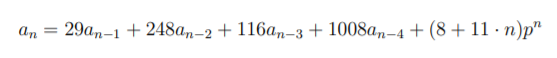

Oraz początkowe wartości ciągu:


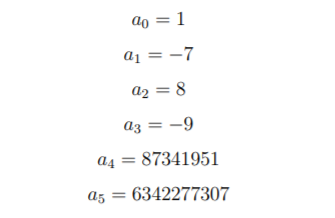

Aby rozwiązać równanie potrzebujemy n+d+1 wartości początkowych. Jednakże mamy podane tylko n wartości początkowych ( równanie jest rzędu n ). Pozostałe d + 1 wartości musimy sami wyznaczyć z równania.

Za pomocą początkowych wartości ciągu oraz podanego równania rekurencyjnego, jesteśmy w stanie wyznaczyć wielomian charakterystyczny.

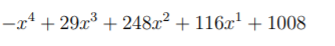

Który po przekształceniu ma postać:

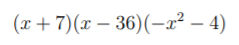



Następnie rozwiązujemy równanie kwadratowe wyznaczając jego pierwiastki:

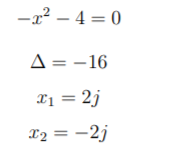

I otrzymujemy pierwiastki wielomianu charakterystycznego:
[ -7 , 36 , 2j , -2j ]

Korzystając z ogólnego równania jednorodnego oraz przewidywanego równania jednorodnego, jesteśmy w stanie przedstawić macierz współczynników równania rekurencyjnego.

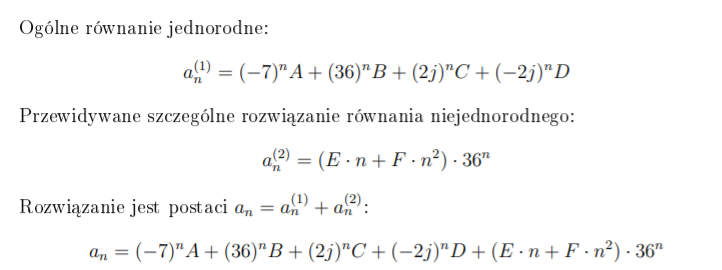

Macierz współczynników:

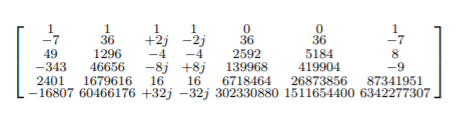


Rozwiązanie macierzy metodą elminacji Gaussa, pozwoli nam znaleźć rozwiązania równania.

Zatem przejdźmy do implementacji.

## 2. Kod


*Kod biblioteki cfraction, która jest wykorzystywana w rozwiązaniu problemu.*


In [ ]:
#!/usr/bin/env python3

"""Implementation of complex numbers (a+b*j) where the real and imaginary components \
are represented as Fraction instances to preserve accuracy during most mathematical \
operations.
When accuracy is lost due to conversion to float in order to perform an operation, \
the result is converted back into a CFraction instance before returning. Of course \
this doesn't recover any accuracy but the type stays the same.
Accuracy is not preserved during the following computations:
    - __abs__(), magnitude implemented as sqrt(a**2 + b**2)
    - __complex__(), converting to a built-in complex type
    - math operations involving a CFraction and an irrational number
        (becomes float during calculation)
    - math operations involving a CFraction and most floating point numbers
        certain floats are able to be converted to Fractions correctly but most aren't
    - CFraction raised to a non-integer power
Aside from the use of the Fraction class to store values, this class attempts to \
behave as closely as possible to the built-in complex class.
"""

import copy
import math
import operator
from collections.abc import Iterable
from fractions import Fraction
from functools import reduce
from numbers import Complex, Rational, Real

class _Fraction(Fraction):
    """Extend Fraction to override __repr__, to match functionality of complex() in the interpreter"""

    def __repr__(self):
        return self.__str__()

class CFraction(Complex):
    """CFraction(real[, imag]) -> complex number with components stored as Fraction instances.
    Create a complex number from a real part and an optional imaginary part. CFraction is interoperable with the built-in complex class, but of course this loses the benefit of Fraction components.
    """

    def __init__(self, real=0, imag=0):
        """Coerce real and imaginary components to fractions"""
        if isinstance(real, Complex) and imag == 0:
            real, imag = (real.real, real.imag)
        # Support passing tuples as (numerator,denominator) pairs
        self._real = _Fraction(*real) if isinstance(real, Iterable) and len(real) == 2 else _Fraction(real)
        self._imag = _Fraction(*imag) if isinstance(imag, Iterable) and len(imag) == 2 else _Fraction(imag)

# Properties
    @property
    def real(self):
        """Real component of complex number"""
        return self._real

    @property
    def imag(self):
        """Imaginary component of complex number"""
        return self._imag

# Methods
    def conjugate(self):
        """Return complex conjugate (negated imaginary component)"""
        return CFraction(self.real, -1 * self.imag)

    def limit_denominator(self, max_denominator=1000000):
        """Limit length of fraction at the cost of some accuracy"""
        return CFraction(self.real.limit_denominator(max_denominator),
                         self.imag.limit_denominator(max_denominator))

# Comparison operators
    def __eq__(self, other):
        """Check equality with CFractions or other types"""
        if other is None:
            return False

        if isinstance(other, Real):
            return self.imag == 0 and self.real == other
        return self.imag == other.imag and self.real == other.real

    def __ne__(self, other):
        return not self.__eq__(other)

# Unary operators
    def __abs__(self):
        """Return magnitude of complex number sqrt(a**2 + b**2)"""
        return _Fraction(math.sqrt(self.real**2 + self.imag**2))

    def __neg__(self):
        return CFraction(-1 * self.real, -1 * self.imag)

    def __pos__(self):
        return CFraction(self.real, self.imag)

    def __hash__(self):
        """Lifted this algorithm from implementation of built-in complex().__hash__ in complex_hash(PyComplexObject*) in Objects/complexobject.c"""
        hashreal = hash(self.real)
        hashimag = hash(self.imag)

        if hashreal == -1 or hashimag == -1:
            return -1

        combined = hashreal + 1000003 * hashimag
        return -2 if combined == -1 else combined

    def __reduce__(self):
        """Support for pickle"""
        return (self.__class__, (self.real, self.imag))

    def __copy__(self):
        """Support for copy module"""
        return self.__class__(self.real, self.imag)

    def __deepcopy__(self, memo):
        """Support for copy module"""
        return self.__class__(copy.deepcopy(self.real, memo), copy.deepcopy(self.imag, memo))

# Binary operators
    def __add__(self, other):
        return CFraction(self.real + other.real, self.imag + other.imag)

    def __radd__(self, other):
        return self.__add__(other)

    def __sub__(self, other):
        return self.__add__(-1 * other)

    def __rsub__(self, other):
        return (-1 * self).__add__(other)

    def __mul__(self, other):
        return CFraction(self.real * other.real - self.imag * other.imag, self.real * other.imag + self.imag * other.real)

    def __rmul__(self, other):
        return self.__mul__(other)

    def __truediv__(self, other):
        if other == 0:
            raise ZeroDivisionError("complex division by zero")

        return CFraction((self.real * other.real + self.imag * other.imag, other.real**2 + other.imag**2),
                         (self.imag * other.real - self.real * other.imag, other.real**2 + other.imag**2))

    def __rtruediv__(self, other):
        return CFraction(other).__truediv__(self)

    def __div__(self, other):
        return self.__truediv__(other)

    def __rdiv__(self, other):
        return CFraction(other).__truediv__(self)

    def __floordiv__(self, other):
        raise TypeError("can't take floor of complex number.")

    def __rfloordiv__(self, other):
        raise TypeError("can't take floor of complex number.")

    def __divmod__(self, other):
        raise TypeError("can't take floor or mod of complex number.")

    def __rdivmod__(self, other):
        raise TypeError("can't take floor or mod of complex number.")

    def __pow__(a, power):
        """Raise CFraction to power 'power'. 'power' can be Rational, CFraction, or other"""

        if a == 0 and (power.imag != 0 or power.real < 0):
            raise ZeroDivisionError("0 to a negative or complex power")

        if isinstance(power, Rational): # Rational(Real) exponents
            if power.denominator == 1: # integer exponents
                # I think Fraction always stores the sign in the numerator, but I'm not 100% sure.
                # this compensates just in case the numerator and denominator can vary in sign
                power = abs(power.numerator) if power >= 0 else -1 * abs(power.numerator)
                if power >= 0: # for positive and zero powers, just multiply repeatedly
                    return reduce(operator.mul, (a for _ in range(power)), CFraction(1))
                elif power < 0: # for negative exponents, invert fraction then raise to positive power
                    rn, rd = (a.real.numerator, a.real.denominator)
                    jn, jd = (a.imag.numerator, a.imag.denominator)
                    new_d = rn**2 * jd**2 + rd**2 * jn**2
                    return CFraction((rd * rn * jd**2, new_d), (-1 * rd**2 * jn * jd, new_d))**abs(power)

            else: # non-integer exponents use this https://stackoverflow.com/questions/3099403/calculating-complex-numbers-with-rational-exponents
                theta = math.atan2(a.imag, a.real)
                return CFraction(abs(a)**power * math.cos(power*theta), abs(a)**power * math.sin(power*theta))

        elif isinstance(power, Complex):
            if power.imag == 0 and isinstance(power.real, Rational) and a.real >= 0: # Complex power but actually real number
                return a**power.real

            # use built-in complex power code for complex or irrational powers
            return CFraction(complex(a)**complex(power))

        else:
            raise TypeError("unsupported operand type(s) for ** or pow(): '{}' and '{}'".format(a.__class__.__name__, power.__class__.__name__))

    def __rpow__(power, a):
        return CFraction(a).__pow__(power)

# Conversions
    def __str__(self):
        """(a+bj) or (a-bj) if nonzero real component else bj"""
        if self.real == 0:
            return str(self.imag) + "j"
        return "(" + str(self.real) + ("+" if self.imag >= 0 else "-") + str(abs(self.imag)) + "j)"

    def __repr__(self):
        return self.__str__()

    def __complex__(self):
        """Convert to built-in complex type"""
        return complex(self.real, self.imag)

    def __float__(self):
        raise TypeError("can't convert CFraction to float")

    def __int__(self):
        raise TypeError("can't convert CFraction to int")


W programie zostały wykorzystane cztery biblioteki:
- numpy, która umożliwa nam szybkie i sprawne wykonywanie operacji na macierzach oraz funkcje niezbędne do działania biblioteki matplotlib
- cmath, moduł ten zapewnia dostęp do funkcji matematycznych dla liczb zespolonych
- cfractions oraz fractions, moduły zapewniające obsługę liczb wymiernych w arytmetyce

In [ ]:
import numpy
import cmath
import fractions
#import cfractions

Funkcja *Horner*, korzysta z *numpy.polyval(a,b)*. Zadaniem tej funkcji jest ocena wielomianu.

Funkcja *Podziel Wielomian Horner* przedstawia metodę Hornera, która jest sposobem dzielenia wielomianów. Ważne jest aby wykorzystując schemat Hornera mieć wielomian uporządkowany od najwyższej potęgi x, a dwumian który dzielimy musi być stopnia pierwszego typu *x+c* lub *x-c*, gdzie *c* jest dowolną liczbą rzeczywistą.



In [ ]:
def horner(wielomian, x):
    return numpy.polyval(wielomian, x)

In [ ]:
def podziel_wielomian_horner(wielomian, pierwiastek):
    wynik = wielomian[0: 1]  # lista na wspolczynniki nowego wielomianu, pierwszy wspolczynnik sie nie zmienia
    for indeks in range(1, len(wielomian)):
        wynik.append(wielomian[indeks] + wynik[indeks - 1] * pierwiastek)

    return wynik[:-1]  # odcinamy ostatni wspolczynnik bo jest rowny 0

Funkcja *Pierwiastki Równania Kwadratowego* znajduję pierwiastki równania kwadratowego.

In [ ]:
def pierwiastki_rownania_kwadratowego(wielomian):
    a = wielomian[0]
    b = wielomian[1]
    c = wielomian[2]
    delta = b * b - 4 * a * c
    pierwiastek_delta = cmath.sqrt(delta)
    x1 = (-b - CFraction(pierwiastek_delta.real, pierwiastek_delta.imag)) / 2 * a
    x2 = (-b + CFraction(pierwiastek_delta.real, pierwiastek_delta.imag)) / 2 * a
    return [x1, x2]

Funkcja *Dzielniki* znajduje liczbę *a*, która dzieli liczbę naturalną *b* bez reszty. 

In [ ]:
def dzielniki(liczba):
    wynik = []  # deklarujemy pusta liste dzielnikow
    for mozliwy_dzielnik in range(1, abs(liczba) + 1):
        if abs(liczba) % mozliwy_dzielnik == 0 and mozliwy_dzielnik not in wynik:
            wynik.append(mozliwy_dzielnik)  # znaleziono nowy dzielnik, dodaj do wyniku
            wynik.append(-1 * mozliwy_dzielnik)  # dodaj z przeciwnym znakiem

    return wynik

Funkcja *Pierwiastki Wielomianu* wykorzystuje poprzednie funkcję, aby można było znaleźć pierwiastki wielomianu charakterystycznego.

In [ ]:
def mozliwe_pierwiastki_wymierne(wielomian):
    wynik = []  # pusta lista na mozliwe pierwiastki
    dzielniki_wyrazu_wolnego = dzielniki(wielomian[-1])
    dzielniki_wyrazu_przy_najwyzszej_potedze = dzielniki(wielomian[0])
    for ostatni in dzielniki_wyrazu_wolnego:
        for pierwszy in dzielniki_wyrazu_przy_najwyzszej_potedze:
            mozliwy_pierwiastek = fractions.Fraction(ostatni, pierwszy)
            if mozliwy_pierwiastek not in wynik:
                wynik.append(mozliwy_pierwiastek)

    return wynik


def pierwiastki_wielomianu(wielomian):
    pierwiastki_wymierne = []  # pusta lista na pierwiastki
    mozliwe_wymierne = mozliwe_pierwiastki_wymierne(wielomian)
    for wymierny in mozliwe_wymierne:
        if horner(wielomian, wymierny) == 0:
            pierwiastki_wymierne.append(wymierny)

    if len(pierwiastki_wymierne) == 2:
        for pierwiastek in pierwiastki_wymierne:
            wielomian = podziel_wielomian_horner(wielomian, pierwiastek)
    else:
        return numpy.roots(wielomian)  # jezeli wielomian nie ma dwoch pierwiastkow wymiernych to uzyj numpy

    pierwiastki_kwadratowego = pierwiastki_rownania_kwadratowego(wielomian)
    return pierwiastki_wymierne + pierwiastki_kwadratowego

In [ ]:
def stworz_macierz_ukladu_rownan(wspolczynniki, wyrazy):
    macierz = []
    x = 0
    for wyraz in wyrazy:
        macierz.append([wspolczynnik**x for wspolczynnik in wspolczynniki] + [wyraz])
        x += 1

    return numpy.matrix(macierz)

Funkcja *Gauss* przedstawia algorytm rozwiązywania układów równań liniowych, który polega na sprowadzeniu macierzy powstałej z równań do postaci macierzy trójkątnej, czyli o uzyskanie zera pod przekątną .

In [ ]:
def gauss(macierz):
    m = len(macierz)
    n = m + 1

    for k in range(m):
        pivots = [abs(macierz[i][k]) for i in range(k, m)]
        i_max = pivots.index(max(pivots)) + k

        macierz[k], macierz[i_max] = macierz[i_max], macierz[k]

        for i in range(k + 1, m):
            f = macierz[i][k] / macierz[k][k]
            for j in range(k + 1, n):
                macierz[i][j] -= macierz[k][j] * f

            macierz[i][k] = 0

    x = []
    for i in range(m - 1, -1, -1):
        x.insert(0, macierz[i][m] / macierz[i][i])
        for k in range(i - 1, -1, -1):
            macierz[k][m] -= macierz[k][i] * x[0]
    return x

Implementacja za pomocą grafów.

Klasa *Wezel* reprezentuje graf, składający się ze zbioru wierzchołków.

Funkcja *Graf* przedstawia równanie, które reprezentuje wiersz macierzy.

Funkcja *Rysuj Graf* w sposób graficzny przedstawia graf.


In [ ]:
import networkx as nx
import pandas as pd

class Wezel:
    def __init__(self, label):
        self.label = label

    def __str__(self):
        return str(self.label)

def graf(tabela_wspolczynnikow, wynik):
    graf = nx.DiGraph()
    wezel = Wezel(wynik)
    bazowy = Wezel("=")
    graf.add_node(bazowy)
    graf.add_edge(bazowy, wezel)
    lista = tabela_wspolczynnikow[:]

    liczba_wspolczynnikow = len(lista)

    for i in range(liczba_wspolczynnikow):
        dodaj = Wezel("+")
        graf.add_edge(bazowy, dodaj)
        bazowy = dodaj
        razy = Wezel("*")
        graf.add_edge(bazowy, razy)
        graf.add_edge(razy, Wezel(lista[i]))
        if i == 0:
            graf.add_edge(razy, Wezel("A"))
        elif i == 1:
            graf.add_edge(razy, Wezel("B"))
        elif i == 2:
            graf.add_edge(razy, Wezel("C"))
        elif i == 3:
            graf.add_edge(razy, Wezel("D"))

    return graf


def rysuj_graf(graph):
    df = pd.DataFrame(index=graph.nodes(), columns=graph.nodes())
    for wiersz, dane in nx.shortest_path_length(graph):
        for kolumna, odleglosc in dane.items():
            df.loc[wiersz, kolumna] = odleglosc

    df = df.fillna(df.max().max() / 3)

    nx.draw(graph, node_size=1000, pos=nx.kamada_kawai_layout(graph, dist=df.to_dict()), with_labels=True)


Kod przedstawiający rozwiązanie.

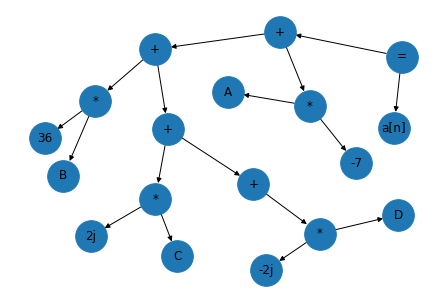

In [ ]:
# wiersz z tabeli wspolczynnikow
wiersz_wspolczynnikow = [1, -7, 8, -9, 29, 248, 116, 1008, 8, 11, 36, 0 + 2j, 0 - 2j, 36, -7]

# numer wiersza
numer_wiersza = 13

# wyrazy a0, a1, a2 oraz a3, elementy listy 'wiersz_wspolczynnikow' od 0 (wlacznie) do 4 (wylacznie)
pierwsze_wyrazy = wiersz_wspolczynnikow[0: 4]

# kolejne wspolczynniki do rownania rekurencyjnego
# a_n = c4 * a_(n-1) + c5 * a_(n-2) + c6 * a_(n-3) + c7 * a_(n-4) + (c8 + c9 * n) * p^n
wspolczynniki_rownania_rekurencyjnego = wiersz_wspolczynnikow[4: 11]

# kolejne wspolczynniki do wielomianu charakterystycznego
# W = -1 * x^4 + c4 * x^3 + c5 * x^2 + c6 * x^1 + c7 * x^0
wspolczynniki_wielomianu_charakterystycznego = [-1] + wspolczynniki_rownania_rekurencyjnego[0: 4]

# pierwiastki wielomianu charakterystycznego z tabeli [-4:] - ostatnie cztery elementy z listy 'wiersz_wspolczynnikow'
pierwiastki_tabela = wiersz_wspolczynnikow[-4:]

pierwiastki_wielomianu_charakterystycznego = pierwiastki_wielomianu(wspolczynniki_wielomianu_charakterystycznego)

rysuj_graf(graf(pierwiastki_wielomianu_charakterystycznego, "a[n]"))


In [ ]:
macierz_gauss = stworz_macierz_ukladu_rownan(pierwiastki_wielomianu_charakterystycznego, pierwsze_wyrazy)

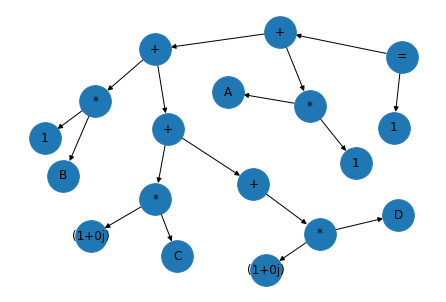

In [ ]:
x = macierz_gauss.tolist()

rysuj_graf(graf([x[0][0],x[0][1],x[0][2],x[0][3]], x[0][4]))

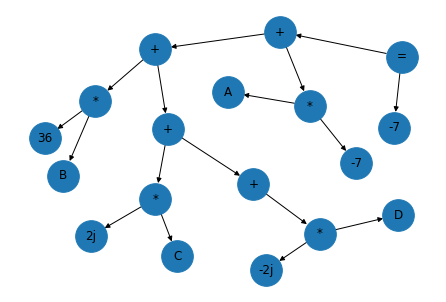

In [ ]:
rysuj_graf(graf([x[1][0],x[1][1],x[1][2],x[1][3]], x[1][4]))

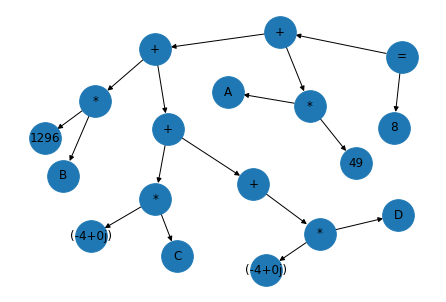

In [ ]:
rysuj_graf(graf([x[2][0],x[2][1],x[2][2],x[2][3]], x[2][4]))

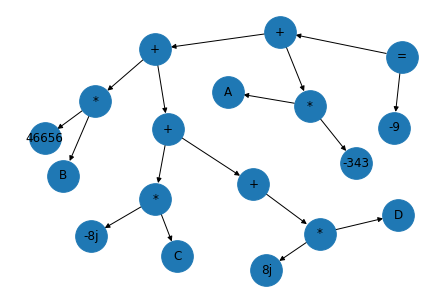

In [ ]:
rysuj_graf(graf([x[3][0],x[3][1],x[3][2],x[3][3]], x[3][4]))

In [ ]:
rozwiazanie_macierzy = gauss(macierz_gauss.tolist())

print(rozwiazanie_macierzy)

[(469/2279+0j), (47/55900+0j), (54663/137800+96283/68900j), (54663/137800-96283/68900j)]


In [ ]:
import numpy
import cmath
import fractions

# plik na wyniki
plik_wynikowy = open("/wyniki.tex", "w")


def poczatek_dokumentu_latex():
    plik_wynikowy.write("\\documentclass[12pt]{article}\n")
    plik_wynikowy.write("\\usepackage[T1]{fontenc}\n")
    plik_wynikowy.write("\\usepackage{amsmath}\n")
    plik_wynikowy.write("\\usepackage[polish]{babel}\n")
    plik_wynikowy.write("\\usepackage[utf8]{inputenc}\n")
    plik_wynikowy.write("\\selectlanguage{polish}\n")
    plik_wynikowy.write("\\title{Rozwiązanie}\n")
    plik_wynikowy.write("\\author{Jolanta Dziewońska}\n")
    plik_wynikowy.write("\\date{}\n")
    plik_wynikowy.write("\\begin{document}\n")
    plik_wynikowy.write("\\maketitle\n")
    plik_wynikowy.write("\\noindent\n")


def koniec_dokumentu_latex():
    plik_wynikowy.write("\\end{document}\n")


def nowa_linia_latex():
    plik_wynikowy.write("\\newline\n")
    plik_wynikowy.write("\\noindent\n")


def nowa_strona():
    plik_wynikowy.write("\\newpage\n")
    plik_wynikowy.write("\\noindent\n")


def tablica_latex(tablica):
    wynik = "$$["
    for wartosc in tablica:
        if isinstance(wartosc, fractions.Fraction):
            if float(wartosc) < 0:
                wynik += "-"
            if float(wartosc).is_integer():
                wynik += str(abs(wartosc.numerator // wartosc.denominator))
            else:
                wynik += "\\frac{" + str(abs(wartosc.numerator)) + "}{" + str(abs(wartosc.denominator)) + "}"
        elif isinstance(wartosc, CFraction):
            if float(wartosc.real) != 0:
                if float(wartosc.real) < 0:
                    wynik += "-"
                if float(wartosc.real).is_integer():
                    wynik += str(abs(wartosc.real.numerator // wartosc.real.denominator))
                else:
                    wynik += "\\frac{" + str(abs(wartosc.real.numerator)) + "}{" + \
                             str(abs(wartosc.real.denominator)) + "}"
            if float(wartosc.imag) != 0:
                if float(wartosc.imag) < 0:
                    wynik += "-"
                else:
                    wynik += "+"
                if float(wartosc.imag).is_integer():
                    wynik += str(abs(wartosc.imag.numerator // wartosc.imag.denominator)) + "j"
                else:
                    wynik += "\\frac{" + str(abs(wartosc.imag.numerator)) + "}{" + \
                             str(abs(wartosc.imag.denominator)) + "}j"
        else:
                wynik += str(wartosc)

        wynik += ", "

    plik_wynikowy.write(wynik[:-2])
    plik_wynikowy.write("]$$\n")


def wielomian_latex(wspolczynniki, pierwiastki, rownanie=False):
    wynik = "$$"
    for pierwiastek in pierwiastki:
        wynik += "(x "
        if pierwiastek < 0:
            wynik += "+" + str(-1 * pierwiastek)
        else:
            wynik += str(-1 * pierwiastek)
        wynik += ")"
    if len(pierwiastki) > 0:
        wynik += "("
    x = len(wspolczynniki) - 1
    for wspolczynnik in wspolczynniki:
        if wspolczynnik == 0:
            x -= 1
            continue
        elif wspolczynnik == -1:
            wynik += "-"
        elif wspolczynnik < 0:
            wynik += str(wspolczynnik)
        else:
            if wynik != "$":
                wynik += "+"
            wynik += str(wspolczynnik)

        if x > 0:
            wynik += "x^{"
            wynik += str(x)
            wynik += "}"
        x -= 1
    if len(pierwiastki) > 0:
        wynik += ")"
    plik_wynikowy.write(wynik)
    if rownanie:
        plik_wynikowy.write("=0")
    plik_wynikowy.write("$$\n")


def rownanie_rekurencyjne_latex(wspolczynniki, n):
    wynik = "$$a_{n}="
    x = 1
    for wspolczynnik in wspolczynniki[0: 4]:
        if wspolczynnik < 0:
            wynik += str(wspolczynnik)
        else:
            if wynik != "$$a_{n}=":
                wynik += "+"
            wynik += str(wspolczynnik)

        wynik += "a_{n - "
        wynik += str(x)
        wynik += "}"
        x += 1
    wynik = wynik + "+(" + str(wspolczynniki[4]) + "+" + str(wspolczynniki[5]) + "\\cdot" + str(n)
    wynik = wynik + ")p^{" + str(n) + "}"
    plik_wynikowy.write(wynik)
    plik_wynikowy.write("$$\n")


def tablica_pierwszych_wyrazow_latex(wyrazy):
    a = 0
    for wyraz in wyrazy:
        plik_wynikowy.write("$$a_{" + str(a) + "}=" + str(wyraz) + "$$\n")
        a += 1


def uklad_latex(pierwiastki, wyrazy):
    wynik = "$$a_n="
    litera = 65
    for pierwiastek in pierwiastki:
        if wynik != "$$a_n=":
            wynik += "+"

        if isinstance(pierwiastek, fractions.Fraction):
            if float(pierwiastek).is_integer():
                wynik += "(" + str(pierwiastek.numerator // pierwiastek.denominator)
            else:
                wynik += "(" + "\\frac{" + str(pierwiastek.numerator) + "}{" + str(pierwiastek.denominator) + "}"
        else:
            wynik += "(" + str(pierwiastek)

        wynik += ")^{n}"
        wynik += str(chr(litera))
        litera += 1

    plik_wynikowy.write(wynik + "$$\n")
    tablica_pierwszych_wyrazow_latex(wyrazy)


def macierz_latex(macierz):
    wynik = "\\[\n\\begin{bmatrix}\n"
    for wiersz in macierz.tolist():
        for wartosc in wiersz:
            if isinstance(wartosc, fractions.Fraction):
                if float(wartosc) < 0:
                    wynik += "-"
                if float(wartosc).is_integer():
                    wynik += str(abs(wartosc.numerator // wartosc.denominator))
                else:
                    wynik += "\\frac{" + str(abs(wartosc.numerator)) + "}{" + str(abs(wartosc.denominator)) + "}"
            elif isinstance(wartosc, CFraction):
                if float(wartosc.real) != 0:
                    if float(wartosc.real) < 0:
                        wynik += "-"
                    if float(wartosc.real).is_integer():
                        wynik += str(abs(wartosc.real.numerator // wartosc.real.denominator))
                    else:
                        wynik += "\\frac{" + str(abs(wartosc.real.numerator)) + "}{" + \
                                 str(abs(wartosc.real.denominator)) + "}"
                if float(wartosc.imag) != 0:
                    if float(wartosc.imag) < 0:
                        wynik += "-"
                    else:
                        wynik += "+"
                    if float(wartosc.imag).is_integer():
                        wynik += str(abs(wartosc.imag.numerator // wartosc.imag.denominator)) + "j"
                    else:
                        wynik += "\\frac{" + str(abs(wartosc.imag.numerator)) + "}{" + \
                                 str(abs(wartosc.imag.denominator)) + "}j"
            else:
                wynik += str(wartosc)
            wynik += "&"
        wynik = wynik[:-1]
        wynik += "\\\\\n"

    wynik = wynik[:-3]
    wynik += "\n\\end{bmatrix}\n\\]\n"
    plik_wynikowy.write(wynik)


def horner(wielomian, x):
    return numpy.polyval(wielomian, x)


def podziel_wielomian_horner(wielomian, pierwiastek):
    wynik = wielomian[0: 1]  # lista na wspolczynniki nowego wielomianu, pierwszy wspolczynnik sie nie zmienia
    for indeks in range(1, len(wielomian)):
        wynik.append(wielomian[indeks] + wynik[indeks - 1] * pierwiastek)

    return wynik[:-1]  # odcinamy ostatni wspolczynnik bo jest rowny 0


def pierwiastki_rownania_kwadratowego(wielomian):
    a = wielomian[0]
    b = wielomian[1]
    c = wielomian[2]
    delta = b * b - 4 * a * c
    plik_wynikowy.write("$$\\Delta = " + str(delta) + "$$\n")
    pierwiastek_delta = cmath.sqrt(delta)
    x1 = (-b - CFraction(pierwiastek_delta.real, pierwiastek_delta.imag)) / 2 * a
    x2 = (-b + CFraction(pierwiastek_delta.real, pierwiastek_delta.imag)) / 2 * a

    plik_wynikowy.write("$$x_1 = " + str(x1) + "$$\n")
    plik_wynikowy.write("$$x_2 = " + str(x2) + "$$\n")
    return [x1, x2]


def dzielniki(liczba):
    wynik = []  # deklarujemy pusta liste dzielnikow
    for mozliwy_dzielnik in range(1, abs(liczba) + 1):
        if abs(liczba) % mozliwy_dzielnik == 0 and mozliwy_dzielnik not in wynik:
            wynik.append(mozliwy_dzielnik)  # znaleziono nowy dzielnik, dodaj do wyniku
            wynik.append(-1 * mozliwy_dzielnik)  # dodaj z przeciwnym znakiem

    return wynik


def mozliwe_pierwiastki_wymierne(wielomian):
    wynik = []  # pusta lista na mozliwe pierwiastki
    dzielniki_wyrazu_wolnego = dzielniki(wielomian[-1])
    dzielniki_wyrazu_przy_najwyzszej_potedze = dzielniki(wielomian[0])
    for ostatni in dzielniki_wyrazu_wolnego:
        for pierwszy in dzielniki_wyrazu_przy_najwyzszej_potedze:
            mozliwy_pierwiastek = fractions.Fraction(ostatni, pierwszy)
            if mozliwy_pierwiastek not in wynik:
                wynik.append(mozliwy_pierwiastek)

    return wynik


def pierwiastki_wielomianu(wielomian):
    pierwiastki_wymierne = []  # pusta lista na pierwiastki
    mozliwe_wymierne = mozliwe_pierwiastki_wymierne(wielomian)
    for wymierny in mozliwe_wymierne:
        if horner(wielomian, wymierny) == 0:
            pierwiastki_wymierne.append(wymierny)

    if len(pierwiastki_wymierne) == 2:
        for pierwiastek in pierwiastki_wymierne:
            wielomian = podziel_wielomian_horner(wielomian, pierwiastek)
    else:
        return numpy.roots(wielomian)  # jezeli wielomian nie ma dwoch pierwiastkow wymiernych to uzyj numpy

    plik_wynikowy.write("Pierwiastki wymierne wielomianu charakterystycznego: \n")
    tablica_latex(pierwiastki_wymierne)
    plik_wynikowy.write("Wielomian charakterystyczny po przekształceniu:")
    wielomian_latex(wielomian, pierwiastki_wymierne)
    plik_wynikowy.write("Pierwiastki równania kwadratowego:")
    wielomian_latex(wielomian, [], True)
    pierwiastki_kwadratowego = pierwiastki_rownania_kwadratowego(wielomian)
    plik_wynikowy.write("Pierwiastki wielomianu charakterystycznego: \n")
    tablica_latex(pierwiastki_wymierne + pierwiastki_kwadratowego)
    return pierwiastki_wymierne + pierwiastki_kwadratowego


def stworz_macierz_ukladu_rownan(wspolczynniki, wyrazy):
    macierz = []
    x = 0
    for wyraz in wyrazy:
        macierz.append([wspolczynnik**x for wspolczynnik in wspolczynniki] + [wyraz])
        x += 1

    return numpy.matrix(macierz)


def gauss(macierz):
    m = len(macierz)
    n = m + 1

    for k in range(m):
        pivots = [abs(macierz[i][k]) for i in range(k, m)]
        i_max = pivots.index(max(pivots)) + k

        macierz[k], macierz[i_max] = macierz[i_max], macierz[k]

        for i in range(k + 1, m):
            f = macierz[i][k] / macierz[k][k]
            for j in range(k + 1, n):
                macierz[i][j] -= macierz[k][j] * f

            macierz[i][k] = 0
        if k != m-1:
            macierz_latex(numpy.matrix(macierz))

    x = []
    for i in range(m - 1, -1, -1):
        x.insert(0, macierz[i][m] / macierz[i][i])
        for k in range(i - 1, -1, -1):
            macierz[k][m] -= macierz[k][i] * x[0]
    return x


poczatek_dokumentu_latex()

# wiersz z tabeli wspolczynnikow
wiersz_wspolczynnikow = [1, -7, 8, -9, 29, 248, 116, 1008, 8, 11, 36, 0 + 2j, 0 - 2j, 36, -7]

# numer wiersza
numer_wiersza = 13

# wyrazy a0, a1, a2 oraz a3, elementy listy 'wiersz_wspolczynnikow' od 0 (wlacznie) do 4 (wylacznie)
pierwsze_wyrazy = wiersz_wspolczynnikow[0: 4]

# kolejne wspolczynniki do rownania rekurencyjnego
# a_n = c4 * a_(n-1) + c5 * a_(n-2) + c6 * a_(n-3) + c7 * a_(n-4) + (c8 + c9 * n) * p^n
wspolczynniki_rownania_rekurencyjnego = wiersz_wspolczynnikow[4: 11]
plik_wynikowy.write("Równanie rekurencyjne: \n")
rownanie_rekurencyjne_latex(wspolczynniki_rownania_rekurencyjnego, numer_wiersza)

# kolejne wspolczynniki do wielomianu charakterystycznego
# W = -1 * x^4 + c4 * x^3 + c5 * x^2 + c6 * x^1 + c7 * x^0
wspolczynniki_wielomianu_charakterystycznego = [-1] + wspolczynniki_rownania_rekurencyjnego[0: 4]
plik_wynikowy.write("Wielomian charakterystyczny: \n")
wielomian_latex(wspolczynniki_wielomianu_charakterystycznego, [])

# pierwiastki wielomianu charakterystycznego z tabeli [-4:] - ostatnie cztery elementy z listy 'wiersz_wspolczynnikow'
pierwiastki_tabela = wiersz_wspolczynnikow[-4:]

pierwiastki_wielomianu_charakterystycznego = pierwiastki_wielomianu(wspolczynniki_wielomianu_charakterystycznego)
nowa_strona()
plik_wynikowy.write("Do rozwiązania układ równań:\n")
uklad_latex(pierwiastki_wielomianu_charakterystycznego, pierwsze_wyrazy)
macierz_gauss = stworz_macierz_ukladu_rownan(pierwiastki_wielomianu_charakterystycznego, pierwsze_wyrazy)
plik_wynikowy.write("Układ równań w postaci macierzy:\n")
macierz_latex(macierz_gauss)
rozwiazanie_macierzy = gauss(macierz_gauss.tolist())
plik_wynikowy.write("Rozwiązania:\n")
tablica_latex(rozwiazanie_macierzy)
koniec_dokumentu_latex()
plik_wynikowy.close()
